In [ ]:
### This Notebook presents the formula for Mutual Information measure as a candidate metric 
### for a future Quality Score for Fraud.net 
### In order to validate MI metric as a quality score measure, this Notebook visualy compares the results of 
### an XGBClassifier against the features selected by our mutual information formula
### although the results were not exactly the same they do resemble the pattern generated by XGBClassifier
### the next step will be to expand this test to all the dataset not just numerical subset to further
### validate this concept

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [3]:
df = pd.read_csv('a.csv')

In [4]:
df.head()

,Unnamed: 0,is_fraud,order_id,ordered_on,compare__bill_email_address_first_name,compare__bill_email_address_full_name,compare__bill_email_address_last_name,compare__distance_billing_address_to_ipv4,compare__ipv4_bill_city,compare__ipv4_bill_country,...,services__persona__score_monetary,services__persona__score_recency,services__persona__score_service,services__persona__service_id,ordered_on_year,ordered_on_month_of_year,ordered_on_day_of_month,ordered_on_day_of_week,is_test,is_train
0,9977,False,1211949743,2017-01-21 20:33:31,0.13,0.13,0.00,NaN,NaN,NaN,...,4.84,4080.0,9.0,acac5eb77b3d1abae8d04e41f84c10ffb1876a16,2017,1,21,7,0,1
1,7229,False,1209582578,2016-11-04 09:40:55,0.50,0.13,0.44,117.879997,0.14,1.0,...,0.01,4830.0,10.0,6780efc9594da147c268ee22d2b69ee93ad2d760,2016,11,4,6,0,1
2,1015,False,1217496472,2017-08-31 20:07:25,0.25,0.42,0.42,22.620001,0.00,1.0,...,0.54,1810.0,7.0,675a2b2c246e1fbf188c5657ad7cc9995e3d601c,2017,8,31,5,0,1
3,2811,False,1213192463,2017-03-15 18:28:30,0.29,0.60,0.71,NaN,NaN,NaN,...,0.40,3890.0,7.0,2dbe3626580c09766eead677b8ed2e1b47fe77ef,2017,3,15,4,0,1
4,7880,True,1215559203,2017-06-23 20:14:46,0.13,0.25,1.00,69.330002,0.07,1.0,...,3.04,2490.0,7.0,f20fab441fb0dd544a470387b89441d40ef3cbf1,2017,6,23,6,0,1


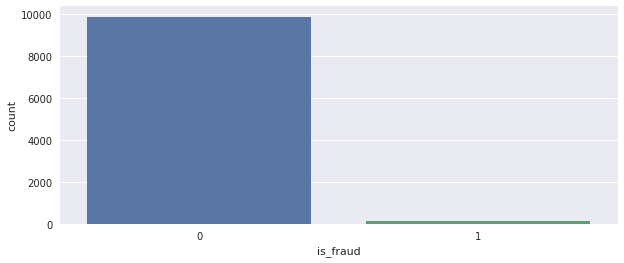

In [5]:
# target column view
target_map = {True: 1, False: 0}
df.is_fraud = df.is_fraud.apply(lambda x: target_map[x])
df_target = df.iloc[:,1]
plt.figure(figsize=(10,4))
sns.countplot(df_target)

In [6]:
## First we narrow the dataset to get numerical and non null data that can be measured statistically using 
## request and target columns

In [6]:
# request columns
df_req = df.iloc[:,np.arange(10,48)]

In [30]:
# check for null values
# print(df_target.isnull().sum()/len(df_target))
# print(df_req.isnull().sum()/len(df_target))
#  request__billing__address2                   1.0000
#  request__custom__credit_limit                1.0000
#  request__custom__v_billing_address_2         0.9598
#  request__custom__v_shipping_address_1        0.9629
#  request__custom__v_shipping_address_2        0.9987
#  request__custom__v_shipping_av_code          0.9629
#  request__custom__v_shipping_city             0.9629
#  request__custom__v_shipping_country          0.9629
#  request__custom__v_shipping_geo              0.9699
#  request__custom__v_shipping_postal_code      0.9629

In [7]:
#  remove the columns with more than 95% nulls
drop_cols = ['request__billing__address2','request__custom__credit_limit','request__custom__v_billing_address_2','request__custom__v_shipping_address_1','request__custom__v_shipping_address_2','request__custom__v_shipping_av_code','request__custom__v_shipping_city','request__custom__v_shipping_country','request__custom__v_shipping_geo','request__custom__v_shipping_postal_code']
df_req = df_req.drop(drop_cols, axis=1)

In [8]:
#  lets focus on numeric columns for now
df_req = df_req.select_dtypes(include='float')

In [9]:
#  first iteration we replace null values with mean for each column
mea1 = df_req['request__custom__rss_score_value'].mean()
df_req['request__custom__rss_score_value'].fillna(mea1, inplace=True)
mea2 = df_req['request__custom__v_billing_postal_code'].mean()
df_req['request__custom__v_billing_postal_code'].fillna(mea2, inplace=True)

In [10]:
# lets make sure we have a clean set of numerical request columns
df_req.isnull().sum()

request__custom__rss_score_value          0
request__custom__user_current_dunning     0
request__custom__user_max_dunning         0
request__custom__v_billing_postal_code    0
request__transaction__order_total         0
request__transaction__total_spent         0
dtype: int64

[0.3003195  0.04952077 0.02076677 0.20926517 0.23961662 0.18051118]


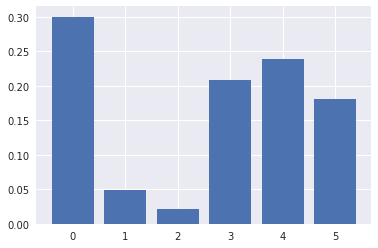

In [19]:
# Here we run a feature selection classifier  XGBClassifier to obtain our array of measures to plot
# plot feature importance 
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(df_req, df_target)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [23]:
# the next step to compute the formula for Mutual Information 
# I(X,Y) =  H_X + H_Y - H_XY
# MI = Entropy of X + Entropy Y - Joint Entropy of X and Y
# Multivariate mutual information
# MMI = I(X1;...;Xn) = I(X1;...;Xn-1) - I(X1;...;Xn-1|Xn)
# MI of 3 variables is I(X,Y,Z) =  H_X + H_Y + H_Z - H_XY - H_XZ - H_YZ + H_XYZ
# https://en.wikipedia.org/wiki/Mutual_information

# Entropy of X  
def en(x):
    # probability of X
    x_ = x / float(np.sum(x))
    # excluiding cero elements since we cannot obtain log2 of 0 and don't affect the result 
    x_ = x_[np.nonzero(x_)]
    # we then compute enthropy
    return -sum(x_* np.log2(x_)) 

# Mutual Information of X,Y 
def mi(x,y,bins):
   # Joint probability distribution of X and Y
   c_XY = np.histogram2d(x,y,bins)[0]
   # Probability distribution of X
   c_X = np.histogram(x,bins)[0]
   # Probability distribution of Y
   c_Y = np.histogram(y,bins)[0]
   # Entropy of X
   H_X = en(c_X)
   # Entropy of Y
   H_Y = en(c_Y)
   # Entropy of XY
   H_XY = en(c_XY) 
   # According to I(X,Y) =  H_X + H_Y - H_XY
   return H_X + H_Y - H_XY

# We set number of bins to get a discrete probability distribution
bins = 50

# The resulting Mutual information for X and Y
mi(df_target, df_req['request__custom__rss_score_value'], bins)



0.02472589728886465

In [27]:
###  We assign a variable for each result of mutual information between target and one numerical column
score_value   = mi(df_target, df_req.request__custom__rss_score_value, bins)       
current_dunning = mi(df_target, df_req.request__custom__user_current_dunning, bins)       
max_dunning = mi(df_target, df_req.request__custom__user_max_dunning, bins)       
postal_code = mi(df_target, df_req.request__custom__v_billing_postal_code, bins)       
order_total = mi(df_target, df_req.request__transaction__order_total, bins)       
total_spent = mi(df_target, df_req.request__transaction__total_spent, bins)       

In [32]:
# we now create an array of measures so we can compare them visually against XGBClassifier
mi_feature_importances = np.array([score_value,current_dunning,max_dunning,postal_code,order_total,total_spent])

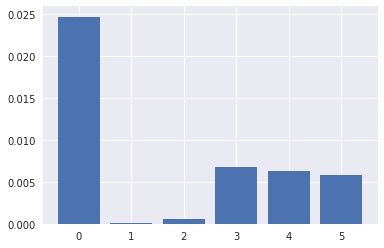

In [33]:
# plotting mutual information measures 
pyplot.bar(range(len(mi_feature_importances)), mi_feature_importances)
pyplot.show()

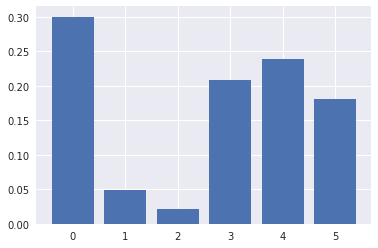

In [34]:
# now lets compare both graphs
# they come close despite having completely different calculations
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()